In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

1.10.0+cu111


In [2]:
from google.colab import files
uploaded=files.upload()

Saving fort.100 to fort.100


In [4]:
import io

In [5]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    
    def __init__(self,file):
     
        self.file=file
        dataset=open(file, "r")
        
        arr_x=np.array([])
        arr_y=np.array([])
        idx=np.array([])
      
        for x in dataset:
          
          arr_x=np.append(arr_x,float(x.split()[1])) #remove ''
          arr_y=np.append(arr_y,float(x.split()[2]))
          idx=np.append(idx,float(x.split()[0]))
        
        self.x=torch.tensor(arr_x)
        self.y=torch.tensor(arr_y)
        self.idx=torch.tensor(idx)
        print(len(idx))
        
    def __len__(self):
        return len(self.x) 
       
    def __getitem__(self,i):
        return self.idx[i],self.x[i],self.y[i]
     

In [6]:
dataset=TimeSeriesDataset('fort.100')
time=[]
x_in=[]
y_in=[]
#for i in range(1000):
trainloader = torch.utils.data.DataLoader(dataset)
for i, data in enumerate(trainloader,0):
    idx, x,y = data
    #print(x,y)
    time.append(idx)
    x_in.append(x)
    y_in.append(y)
#print(y_in)

1000


In [7]:
n_rows,labels = dataset
for row in range(n_rows):
    print(dataset[207:211].to_numpy()[row],labels)
    
    for element, xi,yi in [dataset[207:211].to_numpy()[row]]:
        print(element,xi,yi)

for i in range(len(dataset[208:211].to_numpy())):
    x=torch.tensor([float(dataset[208:211].to_numpy()[i][1])],dtype=torch.float32) #method 2
    y=torch.tensor([float(dataset[208:211].to_numpy()[i][2])],dtype=torch.float32)
    print(x,y) #print final cleaned data
       # label = 2#x.shape, label of data 

ValueError: ignored

In [8]:
class Net(nn.Module):
     def __init__(self):
     #def __init__(self, input_size, output_size, hidden_size):
        super(Net,self).__init__()
        self.input_size = 1# the time feature
        self.hidden1_size = 25#500
        self.hidden2_size = 20#1000
       
        self.output_size = 2
        #define layers
        self.func1 = nn.Sequential(nn.Linear(self.input_size, self.hidden1_size)#,nn.ReLU(),
                                nn.Linear(self.hidden1_size,self.hidden2_size),nn.ReLU(),
                                nn.Linear(self.hidden2_size,self.output_size))
       
     def forward(self,idx):
         
         x_out,y_out=torch.t(self.func1(idx))
        
         return x_out,y_out

In [ ]:
BATCH_SIZE=20
 
from torch.autograd import Variable
trainloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE)#,shuffle=True,num_workers=2)

net = Net()
loss_function = torch.nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=0.000001)
out_x=[]
out_y=[]
for epoch in range(300):
    
    optimizer.zero_grad()
    running_loss_ = Variable(torch.zeros(1))
    for i, data in enumerate(trainloader, 0):
     # get the inputs; data is a list of [inputs, labels]
        idx,input_x, input_y = data
        idx, input_x, input_y = idx.float(), input_x.float(), input_y.float()
        idx=idx.reshape(-1,1)
        # forward + backward + optimize
        idx = Variable(idx)
        input_x = Variable(input_x,requires_grad=True)
        input_y = Variable(input_y,requires_grad=True)
        output_x,output_y=net(idx)
      
        loss_x = loss_function(output_x,input_x.flatten())
        loss_y = loss_function(output_y,input_y.flatten())
        running_loss_ += loss_x+loss_y
        
        optimizer.zero_grad()
        loss_x.backward(retain_graph=True)
        loss_y.backward(retain_graph=True)
        optimizer.step() #update weights
         # print statistics
        
        if i % 20 == 0:   
           print('[%d,%5d] loss: %.3f' %(epoch + 1, i + 1, running_loss_/20))
 #finished training         

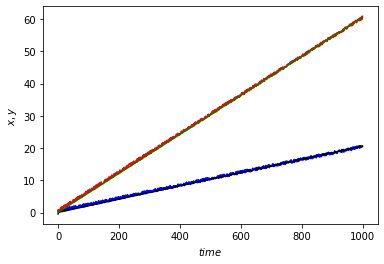

<Figure size 432x288 with 0 Axes>

In [11]:
#plot
import matplotlib.pyplot as plt
timeall=[]
o_x=[]
o_y=[]
for time in range(1000):
     timeall.append(time)
     out_x,out_y =net(torch.tensor(float(time)).unsqueeze(dim=0))
     o_x.append(out_x)
     o_y.append(out_y)

plt.plot(timeall,x_in,'b')
plt.plot(timeall,y_in,'r')
plt.plot(timeall,o_x,'-k')
plt.plot(timeall,o_y,'g')
plt.xlabel('$time$')
plt.ylabel('$x,y$')

plt.show()
plt.savefig('trainedlines_x_blue_y_red.pdf')